## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering


February 9th, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Image Restoration and Reconstruction Notes/Exercises/Sandbox

In [1]:
#Importing the libraries
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
import scipy.fft
import skimage.measure

**Example 5.2 from DIPUM - Using function imnoise to generate noise samples**

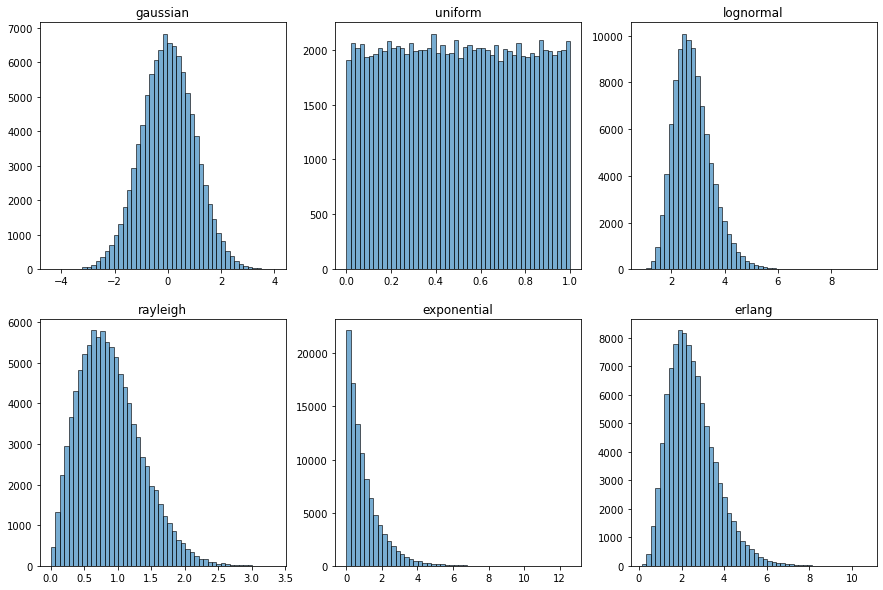

In [2]:
# Generating random noise using function imnoise
M = 100000
N = 1
img_for_noise = np.ones((M, N))

# define noise type list to cycle through
noise_type = ["gaussian", "uniform", "lognormal", "rayleigh", "exponential", "erlang"]

# plot histograms
fig_hist, ax_hist = plt.subplots(2, 3, figsize=(15,10))
ax_hist = ax_hist.ravel()

for idx, type in enumerate(noise_type):
    # Generate noise samples
    _, noise_samples = ec_img_utils.imnoise(img_for_noise, {"type": type})

    # compute histogram
    #hist, ctrs = skimage.exposure.histogram(noise_samples, nbins=50)

    # plot the histogram
    #ax_hist[idx].plot(ctrs, hist)
    ax_hist[idx].hist(noise_samples, bins=50, edgecolor='k', alpha=0.6)
    ax_hist[idx].set_title(type)

#### Estimating Noise Parameters

Our objective here is to estimate the PDF of the noise corrupting our image. We can estimate the noise distribution by
computing a normalized histogram of the intensity values in our noisy image. We can describe the shape of a histogram
by its moments about the mean.

Let $z_i$ be the discrete random variable that denotes the intensity levels in an image and $p(z_i)$, $i = 0, 1, 2, ...,
L - 1$, the corresponding normalized histogram, where $L$ is the number of possible intensity levels. Then, we define
a central moment as:

\begin{equation}
\mu_n =  \sum_{i=0}^{L - 1} (z_i - m)^np(z_i) = 1
\end{equation}

Where $n$ is the **moment order** and $m$ is the mean:

\begin{equation}
m =  \sum_{i=0}^{L - 1} z_ip(z_i) = 1
\end{equation}

Note that for a normalized histogram, the sum of all components is equal to 1, and $p(z_i)$ is an estimate of the
probability of $z_i$.

When estimating the statistical parameters (e.g., noise mean and variance) from a noisy image, the general approach is
to select a region of intensity values with as featureless a background as possible, so that the variability of
intensity values in the region will be due primarily to noise.

In [3]:
# create polygonal binary mask
row_col_for_mask = np.array([[170, 170, 198, 197, 170],[214, 233, 233, 211, 214]])
print(row_col_for_mask)

row_min = np.min(row_col_for_mask[0,:])
row_max = np.max(row_col_for_mask[0,:])

col_min = np.min(row_col_for_mask[1,:])
col_max = np.max(row_col_for_mask[1,:])
#print(row_min)
#print(row_max)
#print(col_min)
#print(col_max)
#plt.imshow(mask,cmap='gray')

[[170 170 198 197 170]
 [214 233 233 211 214]]


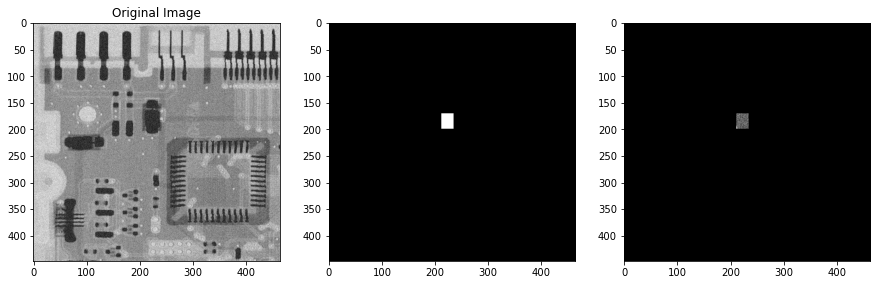

In [4]:
img_ckt = io.imread('./images/circuitboard-gaussian.tif')

# get image dimensions
nrows, ncols = img_ckt.shape

#generate mask
mask = np.zeros((nrows,ncols))
mask[row_min:row_max+1, col_min:col_max+1] = 1
mask = mask.astype(bool)

# display image
fig_ckt, ax_ckt = plt.subplots(1, 3, figsize=(15,5))
ax_ckt = ax_ckt.ravel()

ax_ckt[0].imshow(img_ckt, cmap='gray')
ax_ckt[0].set_title("Original Image");

ax_ckt[1].imshow(mask, cmap='gray')

# pluck the region of interest form the original image
img_ckt_masked = img_ckt * mask

# display masked image
ax_ckt[2].imshow(img_ckt_masked, cmap='gray')

<BarContainer object of 255 artists>

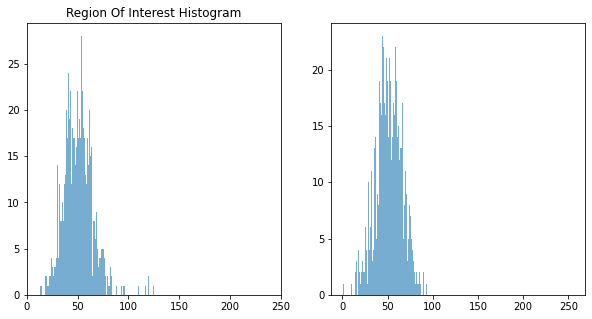

In [5]:
# compute histogram of the region of interest
img_ckt_roi = img_ckt[row_min:row_max + 1, col_min: col_max + 1]

roi_hist, roi_hist_ctrs = skimage.exposure.histogram(img_ckt_roi, nbins = 256, normalize=True)

fig_roi_hist, ax_roi_hist = plt.subplots(1, 2, figsize = (10,5))
ax_roi_hist = ax_roi_hist.ravel()

hist_roi, hist_ctrs_roi = np.histogram(img_ckt_roi, bins=np.arange(0, 257, 1))
#ax_roi_hist[0].hist(img_ckt_roi, bins=256, edgecolor='k', alpha=0.6);
ax_roi_hist[0].bar(hist_ctrs_roi[:-1], hist_roi, alpha=0.6, width=1.)
ax_roi_hist[0].set_title("Region Of Interest Histogram");
ax_roi_hist[0].set_xlim([0, 250]);


# compute the central moments up to order 2 for our region of interest
roi_mean, roi_sec_moment = ec_img_utils.first_second_moment(img_ckt_roi)

# now that we have the central moments, let's generate random samples from a Gaussian distribution
npix = np.prod(img_ckt_roi.shape)
gaussian_samples = ec_img_utils.imnoise(np.ones((npix,1)), {"type": "gaussian", "a": roi_mean, "b": np.sqrt(roi_sec_moment)})

roi_samp_hist, roi_samp_hist_ctrs = np.histogram(gaussian_samples, bins=np.arange(1, 257, 1))
ax_roi_hist[1].bar(roi_samp_hist_ctrs[:-1], roi_samp_hist, alpha=0.6, width=1.)

From the histogram plots shown above, we see that assuming a Gaussian noise distribution was reasonable.

C:\Users\ernes\OneDrive - The Cooper Union for the Advancement of Science and Art\Digital Image Processing-Aurora-R11\DIPUM\Scripts\Digital-Image-Processing\ec_img_utils.py:837: UserWarning: Image dtype is not float. By default denoise_nl_means will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.19 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  img_flt = skimage.restoration.denoise_nl_means(img, patch_size=m)


Text(0.5, 1.0, 'Salt Noise Filtered with\n Arithmetic Mean')

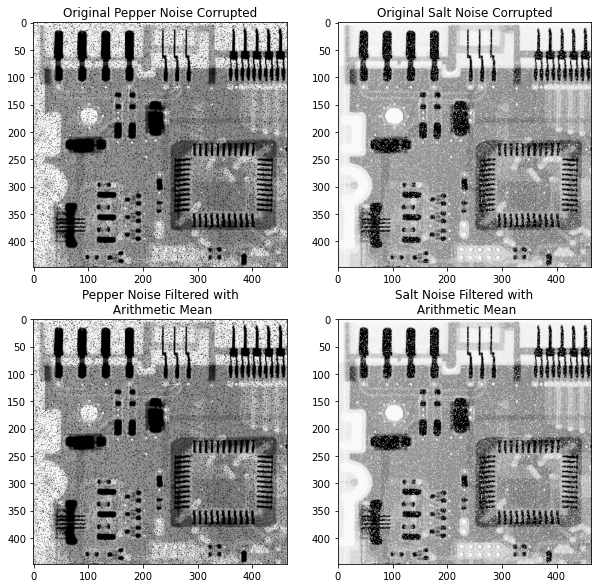

In [13]:
# testing my spatial filter function
img_ckt_pepper = io.imread('./images/circuitboard-pepper.tif')
img_ckt_salt = io.imread('./images/circuitboard-salt.tif')

img_ckt_pepper_avg_flt = ec_img_utils.spatial_fitler(img_ckt_pepper, {"type": "amean"})
img_ckt_salt_avg_flt = ec_img_utils.spatial_fitler(img_ckt_salt, {"type": "amean"})

fig_ckt_spflt, ax_ckt_spflt = plt.subplots(2, 2, figsize=(10, 10))
ax_ckt_spflt = ax_ckt_spflt.ravel()

# display original image
ax_ckt_spflt[0].imshow(img_ckt_pepper, cmap='gray')
ax_ckt_spflt[0].set_title("Original Pepper Noise Corrupted")

ax_ckt_spflt[1].imshow(img_ckt_salt, cmap='gray')
ax_ckt_spflt[1].set_title("Original Salt Noise Corrupted")

# display non-local mean (arithmetic mean) average mean
ax_ckt_spflt[2].imshow(img_ckt_pepper_avg_flt, cmap='gray')
ax_ckt_spflt[2].set_title("Pepper Noise Filtered with\n Arithmetic Mean")

ax_ckt_spflt[3].imshow(img_ckt_salt_avg_flt, cmap='gray')
ax_ckt_spflt[3].set_title("Salt Noise Filtered with\n Arithmetic Mean")

In [6]:
*